# Vehicle Detection Project

The goals / steps of this project are the following:
- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

In [1]:
# Import Section
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import glob
%matplotlib inline
import time
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from skimage.feature import blob_dog, blob_log, blob_doh
from scipy.ndimage.measurements import label
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from moviepy.editor import VideoFileClip
from IPython.display import HTML

/home/siddarthd2919/anaconda3/envs/SDCenvr/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Import the input data

I am using the following images in the folders below as training and test data sets

Training set: 
cars: GTI_far, GTI_left, GTI_right, GTI_MiddleClose 
non-cars: Extra

Test set: 
cars: KITTI_extracted 
non-cars: GTI

Training Data
Car images:     5339
Non-car images: 5068
Image size:     (64, 64, 3)
Test Data
Car images:     2826
Non-car images: 3900
Image size:     (64, 64, 3)


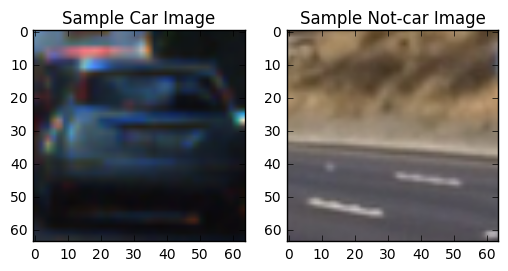

In [2]:
#Train data
cars_train = []
notcars_train = []
# Test Data
cars_test = []
notcars_test = []

# car
images = glob.glob('/home/siddarthd2919/Downloads/CarND-P5-Vehicle-Detection-and-Tracking-master/vehicles/GTI_Far/*.png')
for image in images:
    cars_test.append(image)
    
images = glob.glob('/home/siddarthd2919/Downloads/CarND-P5-Vehicle-Detection-and-Tracking-master/vehicles/GTI_Left/*.png')
for image in images:
    cars_test.append(image)

images = glob.glob('/home/siddarthd2919/Downloads/CarND-P5-Vehicle-Detection-and-Tracking-master/vehicles/GTI_MiddleClose/*.png')
for image in images:
    cars_test.append(image)

images = glob.glob('/home/siddarthd2919/Downloads/CarND-P5-Vehicle-Detection-and-Tracking-master/vehicles/GTI_Right/*.png')
for image in images:
    cars_test.append(image)
# non-cars
images = glob.glob('/home/siddarthd2919/Downloads/CarND-P5-Vehicle-Detection-and-Tracking-master/non-vehicles/Extras/*.png') 
for image in images:
    notcars_train.append(image)


# cars
images = glob.glob('/home/siddarthd2919/Downloads/CarND-P5-Vehicle-Detection-and-Tracking-master/vehicles/KITTI_extracted/*.png') 
for image in images:
    cars_train.append(image)
#non-car
images = glob.glob('/home/siddarthd2919/Downloads/CarND-P5-Vehicle-Detection-and-Tracking-master/non-vehicles/GTI/*.png')
for image in images:
    notcars_test.append(image)
    
# Input Data Summary
def data_summary(car_list, notcar_list):
    data_dict = {}
    data_dict["n_cars"] = len(car_list)
    data_dict["n_notcars"] = len(notcar_list)
    example_img = mpimg.imread(car_list[0])
    data_dict["image_shape"] = example_img.shape
    return data_dict

# Print Data Summary
data_info = data_summary(cars_train, notcars_train)
print('Training Data')
print('Car images:    ', data_info["n_cars"])
print('Non-car images:', data_info["n_notcars"])
print('Image size:    ', data_info["image_shape"])

print('Test Data')
data_info = data_summary(cars_test, notcars_test)
print('Car images:    ', data_info["n_cars"])
print('Non-car images:', data_info["n_notcars"])
print('Image size:    ', data_info["image_shape"])
#print('Data type:     ', data_info["data_type"])


## Plot an example of the car and non car images
car_ind = np.random.randint(0, len(cars_train))
notcar_ind = np.random.randint(0, len(notcars_train))    
car_image = mpimg.imread(cars_train[car_ind])
noncar_image = mpimg.imread(notcars_train[notcar_ind])
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Sample Car Image')
plt.subplot(122)
plt.imshow(noncar_image)
plt.title('Sample Not-car Image')
plt.savefig('car_not_car.jpg')

## Define Features
Define features for the vehicle classification. 
Three types of features are used: 

* Spatial feature
* Color histogram features
* HOG features.



### Spatial Features
Spatial feature uses the raw pixel values of the images and flattens them into a vector. To reduce the size of the image, I performed spatial binning on an image by resizing the image to the lower resolution.

Spatial features size: (192,)


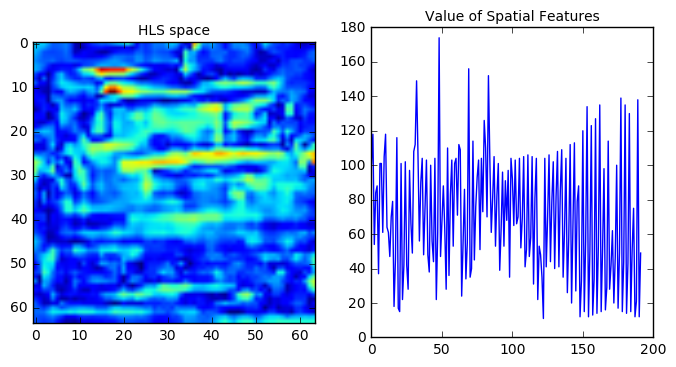

In [3]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)): 
    spatial_features = cv2.resize(img, size).ravel()     
    return spatial_features 

# convert data type to int range from 0 to 255
image_rgb = np.uint8(car_image*255)
# size of the spacial bins
spatial = 8 
# convert it to HLS color space
image_hls = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HLS)
# Extract spatial features, work on the saturation channel
spatial_s = bin_spatial(image_hls, size=(spatial, spatial))
print('Spatial features size:', spatial_s.shape)

# Visualize
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
ax1.imshow(image_hls[:,:,2])
ax1.set_title('HLS space', fontsize=10)
ax2.plot(spatial_s)
ax2.set_title('Value of Spatial Features', fontsize=10)
plt.savefig('spatial.jpg')

### Color Histogram Features
Color Histogram feature is more robust to the different the appearance of the car.  The Color Histogram remove the structural relation and allow more flexibility to the variance of the image.
Binning is performed to the histogram of each channel. Both the RGB and HLS channels are used. 

color histogram features size: (36,)


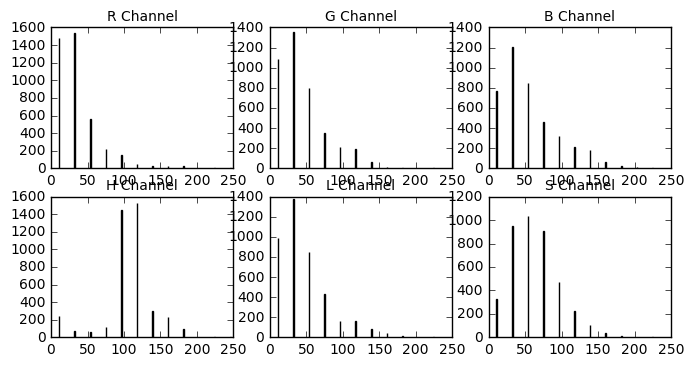

In [4]:
def color_hist(img, nbins=32, bins_range=(0, 256),hist_vec=True):
    hist1 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    hist2 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    hist3 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = hist1[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((hist1[0], hist2[0], hist3[0]))
    
    if hist_vec == False:
        return hist1, hist2, hist3, bin_centers, hist_features
    else:
        return hist_features

# number of bins
histbin = 12
# RGB color space
rh, gh, bh, bincen, hist_rgb = color_hist(image_rgb, nbins=histbin,bins_range=(0, 256),hist_vec=False)
# HLS color space
hh, lh, sh, bincen, hist_hls = color_hist(image_hls, nbins=histbin,bins_range=(0, 256),hist_vec=False)
print('color histogram features size:', hist_rgb.shape)

# Visualize histogram
f, ((ax1, ax2,ax3),(ax4, ax5,ax6) )= plt.subplots(2, 3, figsize=(8,4))
# R Channel
ax1.bar(bincen, rh[0])
ax1.set_title('R Channel', fontsize=10)
# G Channel
ax2.bar(bincen, gh[0])
ax2.set_title('G Channel', fontsize=10)
# B Channel
ax3.bar(bincen, bh[0])
ax3.set_title('B Channel', fontsize=10)
# H Channel
ax4.bar(bincen, hh[0])
ax4.set_title('H Channel', fontsize=10)
# L Channel
ax5.bar(bincen, lh[0])
ax5.set_title('L Channel', fontsize=10)
# S Channel
ax6.bar(bincen, sh[0])
ax6.set_title('S Channel', fontsize=10)
plt.savefig('color_histogram.jpg')

### HOG Feature
Gradient features is also used to capture the signature for a shape. However use the gradient feature directly is sensitive.  Histogram of gradient orientation allows variation  between the shape. The HOG is on the grey scale image.

Hog features shape: (4, 4, 2, 2, 8)
Flatterned Hog features size: (512,)


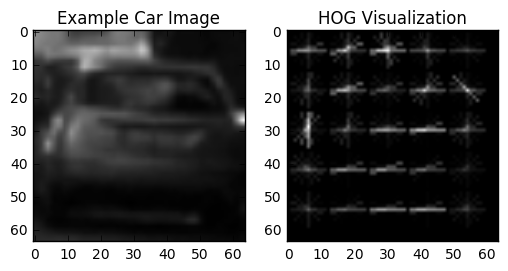

In [5]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block,vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
# convert to gray scale
image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY) 
# Define HOG parameters
orient = 8
pix_per_cell = 12
cell_per_block = 2
# Call our function with vis=True to see an image output,feature_vec=False to get the feature dimension
hog_features, hog_image = get_hog_features(image_gray, orient,pix_per_cell, cell_per_block,vis=True, feature_vec=False)
# flattern the feature to create the feature vector
hog_1d = np.ravel(hog_features) 

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image_gray, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.savefig('HOG_Visualization.jpg')

# test the funtion
print('Hog features shape:', hog_features.shape)
print('Flatterned Hog features size:', hog_1d.shape)

### Extract Features

Combine the outputs of the three features:
* Spatial feature
* Color histogram features
* HOG features

In [6]:
def extract_features(image_rgb):   
    # Spatial feature parameters
    spatial = 8 
    # color histogram feature parameters
    hist_bins = 12 
    # HOG feature parameters
    orient = 8
    pix_per_cell = 12
    cell_per_block = 2    
    # convert it to HLS
    image_hls = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HLS)
    # convert it to grayscale
    image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)        
    # Apply bin_spatial() to get spatial color features on HLS space
    spatial_hls = bin_spatial(image_hls, size=(spatial, spatial))
     # Apply bin_spatial() to get spatial color features on Graysacle 
    spatial_rgb = bin_spatial(image_rgb, size=(spatial, spatial))         
    # Apply color_hist() on HLS space 
    hist_hls = color_hist(image_hls, nbins = hist_bins,bins_range = (0, 256), hist_vec=True) 
    # Apply color_hist() on Graysacle 
    hist_rgb = color_hist(image_rgb, nbins= hist_bins,bins_range = (0, 256), hist_vec=True)     
    # Apply get_hog_features() with vis=False, feature_vec=True
    hog_grey = get_hog_features(image_gray, orient,pix_per_cell, cell_per_block, vis=False, feature_vec=True) 
    # Append the new feature vector to the features list
    features = np.concatenate((spatial_hls,spatial_rgb,hist_hls,hist_rgb,hog_grey))                                    
    return features

# Extract features from the input image
def features_from_data(imgs):
    features_all = []
    for file in imgs:
        image = mpimg.imread(file)
        image_rgb = np.uint8(image*255)
        features = extract_features(image_rgb)        
        features_all.append(features)
    return features_all  

# Extract feature from the training set
car_features_train = features_from_data(cars_train)
notcar_features_train = features_from_data(notcars_train)
X_train = np.vstack((car_features_train, notcar_features_train)).astype(np.float32)   

# Extract feature from the testing set
car_features_test = features_from_data(cars_test) 
notcar_features_test = features_from_data(notcars_test)
X_test = np.vstack((car_features_test, notcar_features_test)).astype(np.float32)   

# print the dataset size
print("Training set:",X_train.shape)
print("Testing set :",X_test.shape)

Training set: (10407, 968)
Testing set : (6726, 968)


### Feature Normalization

I have used the StandardScaler() function to remove the mean and scale it to unit variance. I have also used the numpy hstack() function to make the labels 1 for cars and 0 for non-cars

Training set: (10407, 968)
Test set    : (6726, 968)
Training set: (10407,)
Test set    : (6726,)


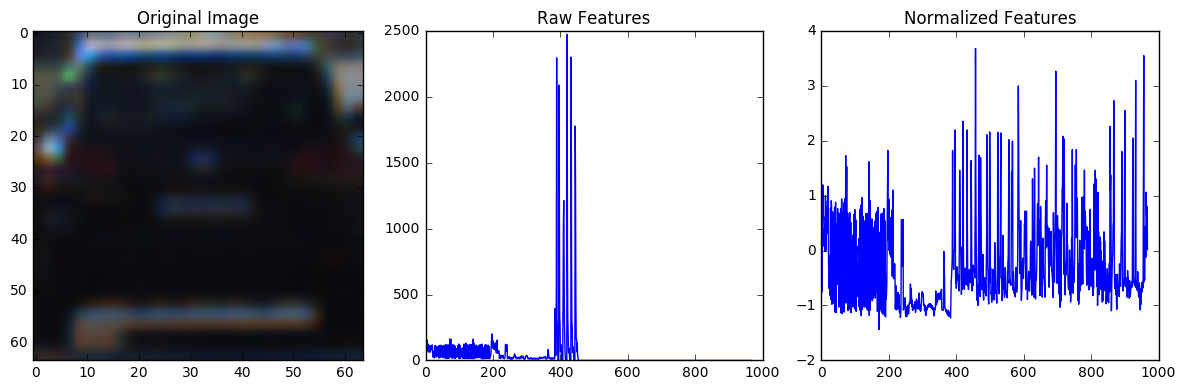

In [7]:
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to the training set
scaled_X_train = X_scaler.transform(X_train)
# Apply the scaler to the testing set
scaled_X_test = X_scaler.transform(X_test)
# Apply hstack() to training set
y_train = np.hstack((np.ones(len(car_features_train)), np.zeros(len(notcar_features_train))))
# Apply hstack() to testing set
y_test = np.hstack((np.ones(len(car_features_test)), np.zeros(len(notcar_features_test))))
# print data size
print('Training set:', scaled_X_train.shape)
print('Test set    :', scaled_X_test.shape)
print('Training set:', y_train.shape)
print('Test set    :', y_test.shape)
# plot feature normalization
car_ind = np.random.randint(0, len(cars_train))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars_train[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X_train[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X_train[car_ind])
plt.title('Normalized Features')
fig.tight_layout()
plt.savefig('Normalize.jpg')

### Create the Training, Testing, and Validation set

- Shuffle the Training set to randomize the data
- Split the Test set into testing and validation set

In [8]:
X_train, y_train = shuffle( scaled_X_train, y_train, random_state=42)
# split the test set into validation set and testing set
X_test, X_valid, y_test, y_valid = train_test_split(scaled_X_test, y_test, test_size=0.5, random_state=42)
print('Training set  :', X_train.shape)
print('Validation set:', X_valid.shape)
print('Testing set   :', X_test.shape)

Training set  : (10407, 968)
Validation set: (3363, 968)
Testing set   : (3363, 968)


## Create the Classifier

- I have used a random forest classifier for this project. 
- We start by using a grid search to find the tuning parameters. 


In [9]:
# max_feature
x = [3,4,6] 
# max_depth 
y = [4,8,25]
# tree leaf
z = [2,4]
# grid search
for i in x:
    for j in y:
        for k in z:
            print ("ftr: {} ,dpt: {} ,lef: {}".format(i,j,k ))
            clf = RandomForestClassifier(n_estimators = 100, max_features = i,max_depth = j,min_samples_leaf = k,random_state = 42,) 
            # fit the classifier
            clf.fit(X_train, y_train)
            # predict
            pred = clf.predict_proba(X_valid)[:,1]
            # compute auroc score
            auroc = roc_auc_score(y_valid, pred)
            print('auroc = ', round(auroc, 4))
clf = RandomForestClassifier(n_estimators=100, max_features = 2,min_samples_leaf = 4,max_depth = 25)
# Check the training time for the SVC
#t=time.time()
clf.fit(X_train, y_train)
#t2 = time.time()
#print(round(t2-t, 2), 'Seconds to train ...')

# Test on training set
pred = clf.predict_proba(X_train)[:,1] 
pred_bi =  clf.predict(X_train) 
auroc = roc_auc_score(y_train, pred)
accuracy  = accuracy_score(y_train, pred_bi) 
print('Training auroc    =', round(auroc, 4))
print('Training accuracy =', round(accuracy, 4))

# Test on test set
pred = clf.predict_proba(X_valid)[:,1] 
pred_bi =  clf.predict(X_valid) 
auroc = roc_auc_score(y_valid, pred) 
accuracy  = accuracy_score(y_valid, pred_bi) 
print('Testing auroc    =', round(auroc, 4))
print('Testing accuracy =', round(accuracy, 4))

# Test on validation set
pred = clf.predict_proba(X_test)[:,1] 
pred_bi =  clf.predict(X_test) 
auroc = roc_auc_score(y_test, pred) 
accuracy  = accuracy_score(y_test, pred_bi) 
print('Validation auroc    =', round(auroc, 4))
print('Validation accuracy =', round(accuracy, 4))

# more data for training always help
# I combine all the data set for training the final model
#X_all = np.concatenate((X_train,X_valid,X_test))
#y_all = np.concatenate((y_train,y_valid,y_test))
# shuffle the data set
#X_all, y_all = shuffle( X_all, y_all, random_state=42) 
#clf.fit(X_all, y_all)


ftr: 3 ,dpt: 4 ,lef: 2
auroc =  0.9736
ftr: 3 ,dpt: 4 ,lef: 4
auroc =  0.9731
ftr: 3 ,dpt: 8 ,lef: 2
auroc =  0.9706
ftr: 3 ,dpt: 8 ,lef: 4
auroc =  0.9712
ftr: 3 ,dpt: 25 ,lef: 2
auroc =  0.9713
ftr: 3 ,dpt: 25 ,lef: 4
auroc =  0.9687
ftr: 4 ,dpt: 4 ,lef: 2
auroc =  0.9644
ftr: 4 ,dpt: 4 ,lef: 4
auroc =  0.9659
ftr: 4 ,dpt: 8 ,lef: 2
auroc =  0.9693
ftr: 4 ,dpt: 8 ,lef: 4
auroc =  0.9707
ftr: 4 ,dpt: 25 ,lef: 2
auroc =  0.9628
ftr: 4 ,dpt: 25 ,lef: 4
auroc =  0.9667
ftr: 6 ,dpt: 4 ,lef: 2
auroc =  0.9628
ftr: 6 ,dpt: 4 ,lef: 4
auroc =  0.9633
ftr: 6 ,dpt: 8 ,lef: 2
auroc =  0.9646
ftr: 6 ,dpt: 8 ,lef: 4
auroc =  0.9612
ftr: 6 ,dpt: 25 ,lef: 2
auroc =  0.9544
ftr: 6 ,dpt: 25 ,lef: 4
auroc =  0.9564
Training auroc    = 1.0
Training accuracy = 0.9998
Testing auroc    = 0.9709
Testing accuracy = 0.8046
Validation auroc    = 0.9682
Validation accuracy = 0.8011


## Vehicle Detection

- I have used the classifer on sliding windows to detect whether an image contain cars
- I use the cv2.rectangle() function to drae boxes in the image
- I have a created a sliding window function that 
    - Computes the span of the region to be searched
    - Compute the number of pixels 
    - Compute the number of windows

In [10]:
# load test images
img1 = cv2.imread('test_images/test1.jpg')
img2 = cv2.imread('test_images/test2.jpg')
img3 = cv2.imread('test_images/test3.jpg')
img4 = cv2.imread('test_images/test4.jpg')
img5 = cv2.imread('test_images/test5.jpg')
img6 = cv2.imread('test_images/test6.jpg')

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    draw_img = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    return draw_img
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]    
    # Compute the number of pixels per step
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))    
    # Compute the number of windows 
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    return window_list


Total number of windows: 128


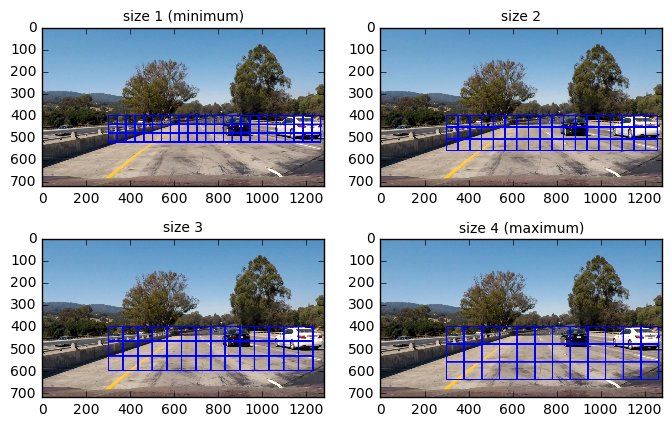

In [11]:
# define the minimum window size
x_min =[300, 1280]
y_min =[400, 530]
xy_min = (80, 80)

# define the maxium window size
x_max =[300, 1280]
y_max =[400, 700]
xy_max = (160, 160)

# intermedian windows
n = 4 # the number of total window sizes
x = []
y = []
xy =[]
# chose the intermediate sizes by interpolation.
for i in range(n):
    x_start_stop =[int(x_min[0] + i*(x_max[0]-x_min[0])/(n-1)), 
                   int(x_min[1] + i*(x_max[1]-x_min[1])/(n-1))]
    y_start_stop =[int(y_min[0] + i*(y_max[0]-y_min[0])/(n-1)), 
                   int(y_min[1] + i*(y_max[1]-y_min[1])/(n-1))]
    xy_window    =[int(xy_min[0] + i*(xy_max[0]-xy_min[0])/(n-1)), 
                   int(xy_min[1] + i*(xy_max[1]-xy_min[1])/(n-1))]
    x.append(x_start_stop)
    y.append(y_start_stop)
    xy.append(xy_window)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)
img5 = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)
img6 = cv2.cvtColor(img6, cv2.COLOR_BGR2RGB)
# visualize different window size
windows1 = slide_window(img1, x_start_stop= x[0], y_start_stop = y[0], 
                    xy_window= xy[0], xy_overlap=(0.5, 0.5))
windows2 = slide_window(img1, x_start_stop= x[1], y_start_stop = y[1], 
                    xy_window= xy[1], xy_overlap=(0.5, 0.5))
windows3 = slide_window(img1, x_start_stop= x[2], y_start_stop = y[2], 
                    xy_window= xy[2], xy_overlap=(0.5, 0.5))
windows4 = slide_window(img1, x_start_stop= x[3], y_start_stop = y[3], 
                    xy_window= xy[3], xy_overlap=(0.5, 0.5))

window_img1 = draw_boxes(img1, windows1, color=(0, 0, 255), thick=6)
window_img2 = draw_boxes(img1, windows2, color=(0, 0, 255), thick=6)                    
window_img3 = draw_boxes(img1, windows3, color=(0, 0, 255), thick=6)
window_img4 = draw_boxes(img1, windows4, color=(0, 0, 255), thick=6)


f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(8,5))
ax1.imshow(window_img1)
ax1.set_title('size 1 (minimum)', fontsize=10)
ax2.imshow(window_img2)
ax2.set_title('size 2', fontsize=10)
ax3.imshow(window_img3)
ax3.set_title('size 3', fontsize=10)
ax4.imshow(window_img4)
ax4.set_title('size 4 (maximum)', fontsize=10)

# combine all windows
windows_all = list(windows1 + windows2 + windows3 + windows4)
print('Total number of windows:',len(windows_all))
plt.savefig('windows.jpg')

### Extract Features from window

- I have preprocessed the image by cropping the window and resizing the image to 64X64

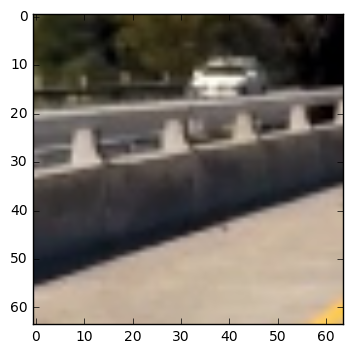

In [12]:
def preprocess(img,window):
    img_crop = img[window[0][1]:window[1][1], window[0][0]:window[1][0]]
    img_resized = cv2.resize(img_crop, (64, 64))
    return img_resized
img = preprocess(img1,windows3[1])
plt.imshow(img)

## Extract Features from a test Image

In [13]:
def features_from_img(img):
    features_all = []    
    for n in range(len(windows_all)):
        image_rgb = preprocess(img,windows_all[n])
        features = extract_features(image_rgb)
        features_all.append(features)       
    scaled_features = X_scaler.transform(features_all)
    return scaled_features

img_features = features_from_img(img1)
pred = clf.predict_proba(img_features)[:,1]
print('The first 10 prediction results', pred[0:10])

The first 10 prediction results [ 0.13335823  0.11765693  0.26686075  0.2335706   0.19730128  0.32357631
  0.34374802  0.23986219  0.15083516  0.12144769]


## Windows with Car Images

- Based on the prediction of the classifier the below function will return the windows with car images.

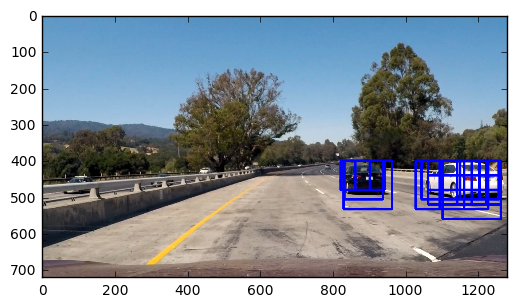

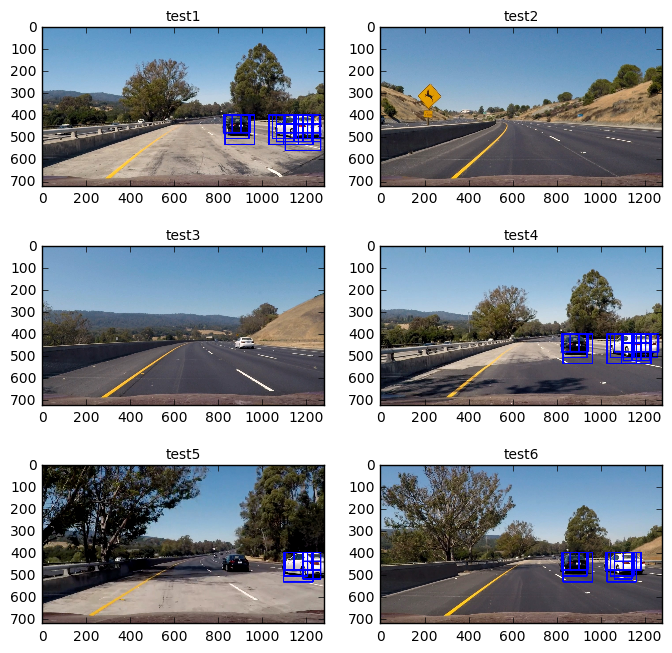

In [14]:
def get_car_windows(pred):
    windows_car = []
    for n in range(len(pred)):
        if pred[n] > 0.51:
            windows_car.append(windows_all[n])
    return windows_car

windows_car = get_car_windows(pred)
img_box = draw_boxes(img1, windows_car, color=(0, 0, 255), thick=6)
plt.imshow(img_box)
plt.savefig('detect.jpg')

def find_cars(img):
    img_features = features_from_img(img)
    pred = clf.predict_proba(img_features)[:,1]
    windows_car = get_car_windows(pred)
    return windows_car

# Test the predictions on the test images provided
windows_car = find_cars(img1)
img_box1 = draw_boxes(img1, windows_car, color=(0, 0, 255), thick=6)

windows_car = find_cars(img2)
img_box2 = draw_boxes(img2, windows_car, color=(0, 0, 255), thick=6)

windows_car = find_cars(img3)
img_box3 = draw_boxes(img3, windows_car, color=(0, 0, 255), thick=6)

windows_car = find_cars(img4)
img_box4 = draw_boxes(img4, windows_car, color=(0, 0, 255), thick=6)

windows_car = find_cars(img5)
img_box5 = draw_boxes(img5, windows_car, color=(0, 0, 255), thick=6)

windows_car = find_cars(img6)
img_box6 = draw_boxes(img6, windows_car, color=(0, 0, 255), thick=6)

f, ((ax1, ax2),(ax3, ax4),(ax5, ax6))= plt.subplots(3, 2, figsize=(8,8))
ax1.imshow(img_box1)
ax1.set_title('test1', fontsize=10)
ax2.imshow(img_box2)
ax2.set_title('test2', fontsize=10)
ax3.imshow(img_box3)
ax3.set_title('test3', fontsize=10)
ax4.imshow(img_box4)
ax4.set_title('test4', fontsize=10)
ax5.imshow(img_box5)
ax5.set_title('test5', fontsize=10)
ax6.imshow(img_box6)
ax6.set_title('test6', fontsize=10)

## Remove Duplicate boxes

- I have created a heatmap to apply thresholds to removal dupicates boxes for the same car.

2 cars found


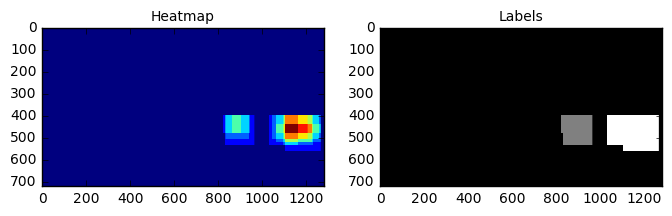

In [15]:
def add_heat(heatmap, boxlist):
    for box in boxlist:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_upper_threshold(heatmap, upper):
    heatmap[heatmap > upper] = 1
    return heatmap
def apply_lower_threshold(heatmap, lower):
    heatmap[heatmap < lower] = 0
    return heatmap
image = img1
bboxes = find_cars(image)
heat = np.zeros_like(image[:,:,0]).astype(np.float)
heatmap = add_heat(heat, bboxes)
labels = label(heatmap)

print(labels[1], 'cars found')

f, (ax1, ax2)= plt.subplots(1, 2, figsize=(8,8))
ax1.imshow(heatmap)
ax1.set_title('Heatmap', fontsize=10)
ax2.imshow(labels[0], cmap='gray')
ax2.set_title('Labels', fontsize=10)
plt.savefig('heatmap.jpg')

## Find the Bounding box of the labels

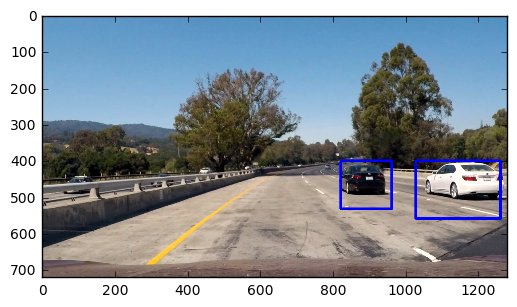

In [16]:
def find_labeled_bboxes(img, labels):
    draw_img = np.copy(img)
    bboxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox)
    return bboxes

image = img1
# find car images
boxes = find_cars(image)
heat = np.zeros_like(image[:,:,0]).astype(np.float)
# increase heatmap value on car images
heatmap = add_heat(heat, boxes)
# apply threshod
heatmap = apply_lower_threshold(heatmap, 1)
# find labels
labels = label(heatmap)
# find bounding boxes
bboxes = find_labeled_bboxes(image, labels)
# draw bounding boxes
img_box = draw_boxes(image, bboxes, color=(0, 0, 255), thick=6)
plt.imshow(img_box)
plt.savefig('boundingboxes.jpg')

## Vehicle Tracking

- I have created a class car() for tracking the position of the car and Bounding box size.
- The cal_dist() function calculates the distance between the centroids
- The track_car() function finds the near by car
- The find_box_centroid_size() function finds the centroid and the bounding box sizes
- The find_car_box() function defines the bounding boxes of the detected cars

In [17]:
class car():
        def __init__(self):
            self.average_centroid= (0,0) 
            self.width = 0 
            self.height = 0 
            self.detected = 0.5  
            
def cal_dist(centroid1, centroid2):
    x1 = centroid1[0]
    y1 = centroid1[1]
    x2 = centroid2[0]
    y2 = centroid2[1]
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)
centroid1 = (1,2)
centroid2 = (2,5)
dist = cal_dist(centroid1, centroid2)
print('Distance:', dist)

def track_car(cntrd,old_Cars):
    threshod_dist = 40 
    Dist = [] 
    if not old_Cars: 
        car_found = False 
        car_id = 0
        return car_found,car_id
    else:
        for car in old_Cars:
            dist = cal_dist(cntrd, car.average_centroid)
            Dist.append(dist)
        car_id = np.argmin(Dist)
        if Dist[car_id] < threshod_dist:
            car_found = True
        else:
            car_found = False
        return car_found, car_id
    
def track_car(cntrd,old_Cars):
    threshod_dist = 40 # the maxium distance to consider nearby
    Dist = [] # a list of distance
    if not old_Cars: # if the list of nearby cars is empty
        # return car not found 
        car_found = False 
        car_id = 0
        return car_found,car_id
    else:
        for car in old_Cars:
            # cacualte the distance
            dist = cal_dist(cntrd, car.average_centroid)
            Dist.append(dist)
        car_id = np.argmin(Dist)
        if Dist[car_id] < threshod_dist:
            car_found = True
        else:
            car_found = False
        return car_found, car_id

def find_car_box(Old_Cars, detected_threshold = 0.51):
    box2 = []
    for car2 in Old_Cars:
        if car2.detected > detected_threshold:
            offset = car2.average_centroid          
            width = car2.width
            height = car2.height
            bbox0 = (int(-width+offset[0]),
                     int(-height+offset[1]))
            bbox1 = (int(width+offset[0]),
                     int(height+offset[1]))
            box2.append((bbox0,bbox1))
    return box2

def find_box_centroid_size(bboxes):
    box_centroids = []
    box_size = []
    
    for box in bboxes:
        x = int((box[0][0] + box[1][0])/2)
        y = int((box[0][1] + box[1][1])/2)
        box_centroids.append((x,y))

        width =  int((box[1][0] - box[0][0])/2)
        height = int((box[1][1] - box[0][1])/2)
        box_size.append((width,height))
    return box_centroids, box_size


Distance: 3.16227766017


## Vehicle Tracking Pipeline

In [18]:
def process_img(image):
    class car():
        def __init__(self):
            self.average_centroid= (0,0) 
            self.width = 0 
            self.height = 0 
            self.detected = 0.5  
    
    global Detected_Cars
    global heatmap
    draw_img = np.copy(image)
    boxes = find_cars(image)
    # draw boxes that contains cars
    draw_img = draw_boxes(draw_img, boxes, color=(0, 0, 255), thick=2)
    # create a new heat map
    heatmap_new = np.zeros_like(image[:,:,0]).astype(np.float)
    # increase heatmap value on windows contain cars
    heatmap_new = add_heat(heatmap_new, boxes)
    heatmap_new = apply_upper_threshold(heatmap_new,1)
    heatmap = 0.9*heatmap + 0.1*heatmap_new
    # wrap heatmap to the orignal image
    wrap_img = np.zeros_like(image) 
    wrap_img[:,:,1] = heatmap[:]*250 
    # blend image with the heat map
    draw_img = cv2.addWeighted(draw_img, 1, wrap_img, 0.5, 0)
    # create a new heatmap to show the heatmap with more certainty by thresholding the heatmap value
    heatmap_sure = np.copy(heatmap)
    heatmap_sure = apply_lower_threshold(heatmap_sure, 0.97)
    #labels of areas
    labels = label(heatmap_sure)
    # finding the bounding box of labeled area
    bounding_boxes = find_labeled_bboxes(image, labels)
    centroids,box_size = find_box_centroid_size(bounding_boxes)
    New_Cars = [] 
    for n in range(len(centroids)):
        # find nearby car object          
        car_found, k = track_car(centroids[n],Detected_Cars)  
        if car_found  == True:
            Detected_Cars[k].average_centroid = (int(0.9*Detected_Cars[k].average_centroid[0] + 0.1*centroids[n][0]),
                                    int(0.9*Detected_Cars[k].average_centroid[1] + 0.1*centroids[n][1]))         
            Detected_Cars[k].width =   math.ceil(0.9*Detected_Cars[k].width + 0.1*box_size[n][0]) # round up
            Detected_Cars[k].height =  math.ceil(0.9*Detected_Cars[k].height + 0.1*box_size[n][1])
            Detected_Cars[k].detected = Detected_Cars[k].detected + 0.2

        else:
            new_car = car()
            new_car.average_centroid = centroids[n]
            new_car.width =  box_size[n][0]
            new_car.height = box_size[n][1]            
            New_Cars.append(new_car)
            
    Detected_Cars2 = list(Detected_Cars)
    Detected_Cars = New_Cars[:] 
    if Detected_Cars2: 
        for car in Detected_Cars2:
            if car.detected > 0.17: 
                Detected_Cars.append(car)
            
    # find car object that is consistent
    car_boxes = find_car_box(Detected_Cars, detected_threshold = 0.55) 
    # draw bounding boxes on car object that is more certain
    draw_img = draw_boxes(draw_img, car_boxes, color=(255, 0, 0), thick=5)         
            
    for car in Detected_Cars:
        car.detected = car.detected*0.8 
    
    return draw_img

## Vehicle Tracking - Video Pipline

The pipline below will be able to detect cars in a video stream

- Detected windows: Blue boxes
- Heatmap: Green area
- Bounding boxes of cars: Red boxes

In [19]:
global Detected_Cars
global heatmap
heatmap = np.zeros_like(img1[:,:,0]).astype(np.float) 
Detected_Cars = []

# output video directory
video_output = 'project5_V2_Output.mp4'
# input video directory
clip1 = VideoFileClip('/home/siddarthd2919/Downloads/CarND-Vehicle-Detection-master/project_video.mp4')
# video processing pipline
video_clip = clip1.fl_image(process_img) 
# write processed files
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project5_V2_Output.mp4
[MoviePy] Writing video project5_V2_Output.mp4


100%|█████████▉| 1260/1261 [15:51<00:00,  1.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project5_V2_Output.mp4 

CPU times: user 15min 40s, sys: 15.1 s, total: 15min 55s
Wall time: 15min 54s
